<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [26]</a>'.</span>

**EXP2 Predicitng Missing Cell-Types from Bulks using BayesPrism Residual**

*This file includes EXP2 results (details outlined in link below).*

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0

Summary: Analyzing results form BayesPrism deconvolution done in EXP2_bayesprism_pbmc.R.

*This file is intended to be run through Papermill in EXP2.py. See EXP2.py for details*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#these parameters are set in papermill 
res_name = "MCT_snadp_EXP2"
pseudos_name = "MCT_snadp_EXP1"
path = "/../data/"
aug_data_path = "/../data/EXP2/"
data_path = "/../data/EXP1/"
bp_path = "/../data/EXP2/BP_results/"
bulk_type = "randomprop_nonoise"
noise_type = "nonoise"
num_missing_cells = [0,1,2,3,4,8,12]
nmf_cut = "minimum_value"
num_samples = 10000

In [3]:
# Parameters
res_name = "MCT_snadp_EXP2"
pseudos_name = "MCT_snadp_EXP1"
path = "/data/"
aug_data_path = "/data/EXP2/"
data_path = "/data/EXP1/"
bp_path = "/data/EXP2/BP_results/"
bulk_type = "randomprop_nonoise"
noise_type = "nonoise"
random_seed = 88
num_missing_cells = [0, 1, 2, 3, 4, 8, 12]
num_samples = 10000
nmf_cut = "minimum_value"
kernel_name = "env_ml"


In [4]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"
bp_path = f"{actual_path}{bp_path}"

Opening mixture file of pseudobulks and anndata for reference:

In [5]:
pseudo_path = os.path.join(aug_data_path, f"{res_name}_{bulk_type}_mixture.csv")
pseudo_path = Path(pseudo_path)
# Open the CSV file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep=",")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
gene_ids = pseudo_df["gene_ids"]
pseudo_df = pseudo_df.T
pseudo_df.columns = gene_ids
pseudo_df = pseudo_df.drop(labels = "gene_ids")
pseudo_df_copy = pseudo_df.copy()

In [6]:
#and importing anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata_copy = sn_adata.copy()
sn_adata

AnnData object with n_obs × n_vars = 116066 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [7]:
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'preadipocyte': 26941, 'mesothelial cell': 26276, 'fat cell': 24825, 'macrophage': 13625, 'endothelial cell': 11480, 'T cell': 3022, 'smooth muscle cell': 2457, 'endothelial cell of lymphatic vessel': 2339, 'pericyte cell': 1165, 'immature NK T cell': 1073, 'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679, 'stromal cell of endometrium': 284, 'B cell': 231, 'neutrophil': 77})


In [8]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw.index = gene_ids.index

In [9]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df.index = gene_ids.index
ref_df_copy = ref_df.copy()

## **Reading In and QCing the BayesPrism Results:**

BayesPrism Results:

In [10]:
#import all BayesPrism results (through using InstaPrism) and real proportions
bp_prop = dict()
real_prop_reb = dict()
real_prop = dict()
ref_bp = dict()
gene_ids = dict()
for num in num_missing_cells:
    bp_results_path = os.path.join(bp_path, f"{res_name}_{num}missing_{noise_type}_InstaPrism_results.csv")
    bp_results_path = Path(bp_results_path)
    # Open the CSV file in read mode
    bp_prop[num] = pd.read_csv(bp_results_path, sep="\t")
    bp_prop[num] = bp_prop[num].T

    #real proportions
    realprop_results_path = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulk_type}_prop.csv")
    realprop_results_path = Path(realprop_results_path)
    # Open the CSV file in read mode
    real_prop[num] = pd.read_csv(realprop_results_path, sep=",")

    #real rebalanced proportions
    realrebprop_results_path = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulk_type}_prop.csv")
    realrebprop_results_path = Path(realrebprop_results_path)
    # Open the CSV file in read mode
    real_prop_reb[num] = pd.read_csv(realrebprop_results_path, sep=",")

    #and the reference used in BP
    ref_results_path = os.path.join(bp_path, f"{res_name}_{num}missing_{noise_type}_InstaPrism_usedref.csv")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_bp[num] = pd.read_csv(ref_results_path, sep="\t")
    #gene ids used for each
    gene_ids[num] = ref_bp[num].index
    #match columns and index
    bp_prop[num].columns =  real_prop[num].columns
    bp_prop[num].index =  real_prop[num].index

In [11]:
real_prop = real_prop_reb

QC imported files:

In [12]:
bp_prop[0]

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,smooth muscle cell,B cell,dendritic cell,mast cell,monocyte,stromal cell of endometrium,immature NK T cell,neutrophil
0,2.008685e-03,0.169776,6.212701e-02,0.020090,0.033116,0.082748,0.052215,3.072472e-19,0.091554,0.122816,0.041554,0.111774,0.028351,0.103028,0.060368,0.018474
1,6.279407e-02,0.042281,2.825980e-02,0.062217,0.061971,0.132478,0.028918,2.601605e-03,0.072856,0.021353,0.285918,0.049623,0.053032,0.020880,0.039983,0.034834
2,2.164624e-02,0.131873,1.727945e-03,0.006892,0.077664,0.015200,0.024097,1.008117e-01,0.024635,0.107468,0.201185,0.160340,0.026763,0.037116,0.025751,0.036829
3,3.834269e-02,0.062532,6.115074e-02,0.020867,0.060540,0.058211,0.015266,7.608210e-02,0.012366,0.025336,0.034371,0.026681,0.032010,0.434706,0.028479,0.013060
4,1.494829e-01,0.036584,1.750113e-02,0.063737,0.024805,0.047398,0.033406,4.394683e-02,0.013806,0.027512,0.008341,0.123320,0.096854,0.029663,0.255566,0.028076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.493019e-24,0.057956,9.571871e-02,0.192284,0.018030,0.102695,0.089471,1.049038e-02,0.038228,0.056548,0.013246,0.076077,0.031756,0.019088,0.107853,0.090557
996,5.941055e-03,0.303442,2.835658e-23,0.029342,0.076781,0.013136,0.038932,5.302342e-03,0.048080,0.037106,0.114182,0.196186,0.065284,0.014366,0.040032,0.011886
997,1.594345e-01,0.007792,4.586536e-02,0.004556,0.028219,0.031282,0.026306,2.051651e-02,0.042199,0.017814,0.112336,0.089181,0.109215,0.141977,0.061621,0.101684
998,2.084470e-27,0.262610,3.905283e-88,0.103864,0.259229,0.011376,0.025481,2.768853e-02,0.038302,0.092954,0.047308,0.012173,0.031514,0.014594,0.052552,0.020352


In [13]:
real_prop[0]

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,smooth muscle cell,B cell,dendritic cell,mast cell,monocyte,stromal cell of endometrium,immature NK T cell,neutrophil
0,0.0170,0.0828,0.0184,0.1654,0.0440,0.0086,0.0406,0.0310,0.0194,0.0846,0.1930,0.0238,0.0174,0.1098,0.0414,0.1028
1,0.0384,0.0652,0.0100,0.0718,0.0070,0.0578,0.1192,0.0882,0.1252,0.0188,0.0544,0.0222,0.0228,0.1472,0.0934,0.0584
2,0.0196,0.2212,0.0452,0.0206,0.0690,0.0346,0.0396,0.0610,0.0334,0.0654,0.0260,0.0582,0.0228,0.0710,0.1398,0.0726
3,0.0244,0.0496,0.0200,0.0106,0.0374,0.0268,0.1622,0.0102,0.0998,0.0756,0.0580,0.2796,0.0056,0.0110,0.0788,0.0504
4,0.0424,0.0186,0.0392,0.0344,0.1494,0.0218,0.0566,0.0730,0.0176,0.2000,0.0062,0.0082,0.0228,0.2476,0.0266,0.0356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0178,0.0338,0.0186,0.1068,0.1320,0.0208,0.0462,0.0398,0.0176,0.2216,0.0562,0.0102,0.1556,0.0622,0.0498,0.0110
996,0.0234,0.0090,0.0342,0.0346,0.4020,0.0110,0.0340,0.0956,0.0182,0.0512,0.1064,0.0352,0.0144,0.0562,0.0630,0.0116
997,0.0762,0.0582,0.0854,0.0210,0.0434,0.1606,0.0316,0.0172,0.0754,0.0450,0.0504,0.0906,0.0478,0.0540,0.0786,0.0646
998,0.0390,0.0964,0.0360,0.0626,0.0102,0.0440,0.0314,0.1002,0.0158,0.0398,0.0010,0.0330,0.0348,0.2148,0.2360,0.0050


In [14]:
real_prop_reb[0]

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,smooth muscle cell,B cell,dendritic cell,mast cell,monocyte,stromal cell of endometrium,immature NK T cell,neutrophil
0,0.0170,0.0828,0.0184,0.1654,0.0440,0.0086,0.0406,0.0310,0.0194,0.0846,0.1930,0.0238,0.0174,0.1098,0.0414,0.1028
1,0.0384,0.0652,0.0100,0.0718,0.0070,0.0578,0.1192,0.0882,0.1252,0.0188,0.0544,0.0222,0.0228,0.1472,0.0934,0.0584
2,0.0196,0.2212,0.0452,0.0206,0.0690,0.0346,0.0396,0.0610,0.0334,0.0654,0.0260,0.0582,0.0228,0.0710,0.1398,0.0726
3,0.0244,0.0496,0.0200,0.0106,0.0374,0.0268,0.1622,0.0102,0.0998,0.0756,0.0580,0.2796,0.0056,0.0110,0.0788,0.0504
4,0.0424,0.0186,0.0392,0.0344,0.1494,0.0218,0.0566,0.0730,0.0176,0.2000,0.0062,0.0082,0.0228,0.2476,0.0266,0.0356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0178,0.0338,0.0186,0.1068,0.1320,0.0208,0.0462,0.0398,0.0176,0.2216,0.0562,0.0102,0.1556,0.0622,0.0498,0.0110
996,0.0234,0.0090,0.0342,0.0346,0.4020,0.0110,0.0340,0.0956,0.0182,0.0512,0.1064,0.0352,0.0144,0.0562,0.0630,0.0116
997,0.0762,0.0582,0.0854,0.0210,0.0434,0.1606,0.0316,0.0172,0.0754,0.0450,0.0504,0.0906,0.0478,0.0540,0.0786,0.0646
998,0.0390,0.0964,0.0360,0.0626,0.0102,0.0440,0.0314,0.1002,0.0158,0.0398,0.0010,0.0330,0.0348,0.2148,0.2360,0.0050


In [15]:
ref_bp[0]

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,smooth muscle cell,immature NK T cell,B cell,dendritic cell,mast cell,monocyte,stromal cell of endometrium,neutrophil
A1BG,9.967396e-06,1.000000e-08,1.652261e-06,1.134214e-05,7.647768e-07,3.493282e-06,1.123916e-05,8.460828e-06,1.309437e-05,2.729497e-06,3.595767e-06,6.512416e-06,8.763812e-06,3.950554e-06,7.433806e-06,1.000000e-08
A1BG-AS1,1.811436e-05,1.718946e-06,1.068470e-05,1.443273e-05,2.274330e-06,8.718205e-06,1.204124e-05,2.113707e-05,1.848205e-05,9.074991e-06,1.614595e-05,2.091062e-05,2.357796e-05,1.330937e-05,1.782713e-05,1.000000e-08
A1CF,9.152178e-07,1.149297e-06,8.311306e-07,1.040195e-06,7.647768e-07,1.000000e-08,8.120829e-07,2.122707e-06,1.000000e-08,1.000000e-08,1.000000e-08,9.389166e-07,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
A2M,1.104466e-04,1.173576e-04,3.539173e-04,1.833847e-04,9.223473e-04,1.724325e-04,4.604056e-04,6.105823e-04,3.740691e-04,3.408537e-04,9.682571e-05,2.591777e-04,1.025553e-03,7.192511e-05,9.800424e-05,1.513787e-04
A2M-AS1,3.630871e-06,7.415431e-06,4.936784e-06,1.040195e-06,2.416286e-05,7.847385e-06,3.218332e-06,5.071497e-05,3.858344e-06,4.986745e-05,1.256019e-05,3.725667e-06,1.468047e-04,2.472846e-06,2.979522e-06,1.000000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OR2B11,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,5.025692e-07,1.000000e-08,1.000000e-08
POU4F1,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.802884e-06,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
AC105924.1,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,4.744583e-07,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
AC239803.3,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,5.025692e-07,1.000000e-08,1.000000e-08


In [16]:
#The BayesPrism reference should sum to 1 for each cell type expression
ref_bp[0].sum(axis =0)

mesothelial cell                        1.0
fat cell                                1.0
macrophage                              1.0
preadipocyte                            1.0
endothelial cell                        1.0
endothelial cell of lymphatic vessel    1.0
pericyte cell                           1.0
T cell                                  1.0
smooth muscle cell                      1.0
immature NK T cell                      1.0
B cell                                  1.0
dendritic cell                          1.0
mast cell                               1.0
monocyte                                1.0
stromal cell of endometrium             1.0
neutrophil                              1.0
dtype: float64

In [17]:
pseudo_df_copy

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,44.0,157.0,10.0,3651.0,210.0,19.0,416.0,13.0,164.0,0.0,...,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,4.0,0.0
1,58.0,141.0,2.0,3072.0,146.0,25.0,438.0,5.0,204.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,40.0,144.0,5.0,3774.0,274.0,26.0,316.0,10.0,148.0,3.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
3,57.0,172.0,4.0,3319.0,193.0,51.0,328.0,12.0,157.0,2.0,...,1.0,0.0,0.0,0.0,7.0,0.0,0.0,3.0,0.0,0.0
4,67.0,198.0,1.0,3287.0,248.0,27.0,315.0,10.0,139.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,63.0,126.0,4.0,2743.0,124.0,34.0,376.0,10.0,205.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,60.0,164.0,11.0,4107.0,276.0,29.0,502.0,16.0,167.0,4.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0
997,47.0,169.0,2.0,3139.0,216.0,20.0,262.0,6.0,73.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
998,27.0,80.0,12.0,5006.0,233.0,49.0,690.0,14.0,244.0,4.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0


In [18]:
ref_df_copy

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,smooth muscle cell,B cell,dendritic cell,mast cell,monocyte,stromal cell of endometrium,immature NK T cell,neutrophil
A1BG,0.053714,0.001452,0.031696,0.012824,0.003145,0.026615,0.052988,0.033390,0.053714,0.022744,0.042826,0.035809,0.029519,0.037261,0.027341,0.000000
A1BG-AS1,0.116138,0.007501,0.089039,0.032664,0.008226,0.062182,0.095088,0.080813,0.092911,0.099202,0.171546,0.098234,0.088314,0.097266,0.048149,0.000000
A1CF,0.002178,0.023954,0.001452,0.003145,0.003387,0.008468,0.001210,0.003145,0.003387,0.000000,0.009436,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,0.403339,0.575611,1.000000,0.553351,1.000000,0.997580,1.000000,1.000000,1.000000,0.549964,1.000000,1.000000,0.499637,0.563513,1.000000,0.304863
A2M-AS1,0.018389,0.064360,0.028309,0.026131,0.062908,0.037987,0.018631,0.357851,0.021534,0.082265,0.027099,0.586741,0.015243,0.017905,0.284781,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,0.000726,0.000000,0.000242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL109945.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HIST1H3G,0.000242,0.000000,0.000000,0.000484,0.000000,0.000000,0.000000,0.000000,0.000968,0.000000,0.007259,0.000000,0.002420,0.000000,0.000000,0.000000
PAEP,0.002903,0.000968,0.000726,0.000968,0.000726,0.000000,0.002420,0.000000,0.001210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
#cutting to genes used in each one
pseudo_df = dict()
sn_adata = dict()
ref_df = dict()
for num in num_missing_cells:
    pseudo_df[num] = pseudo_df_copy[gene_ids[num]]
    sn_adata[num] = sn_adata_copy[:, gene_ids[num]]
    ref_df[num] = ref_df_copy.loc[gene_ids[num], :]
    #and matching columns of present cells
    ref_df[num] = ref_df[num].filter(ref_bp[num].columns)

Visualize BayesPrism proportions:

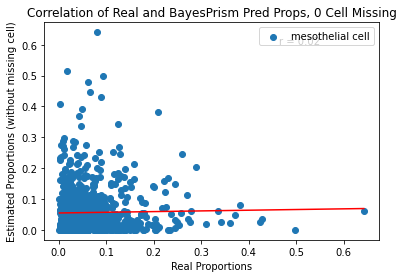

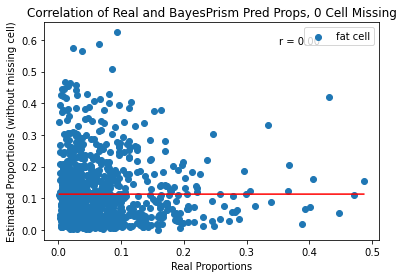

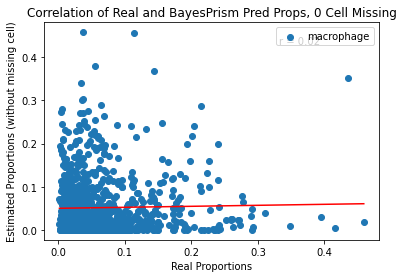

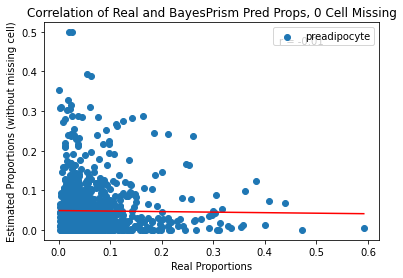

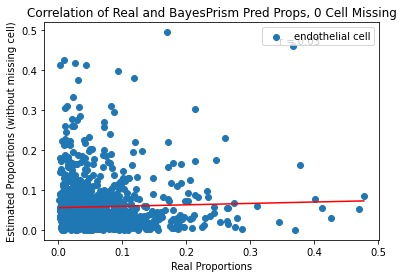

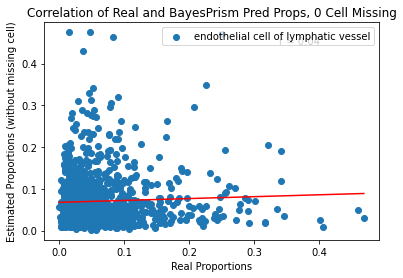

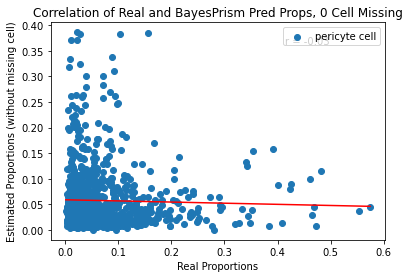

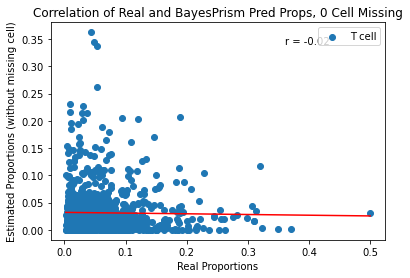

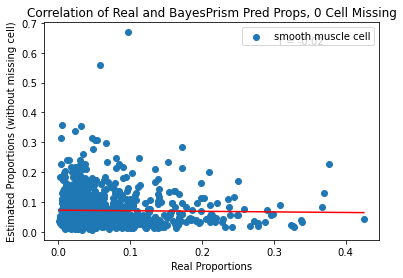

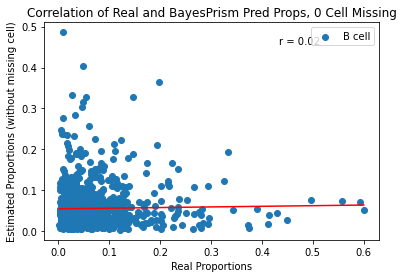

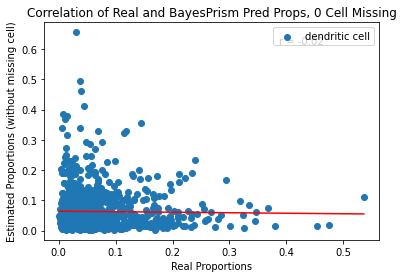

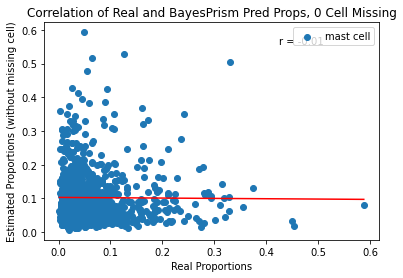

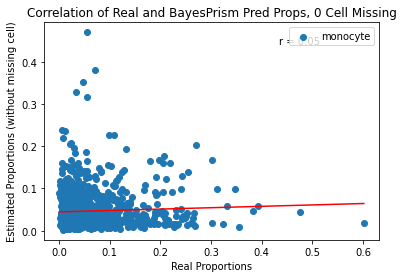

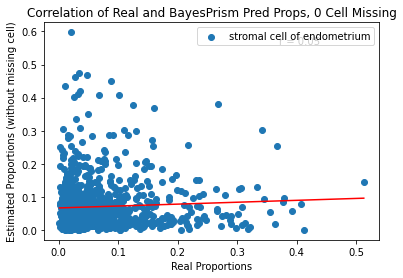

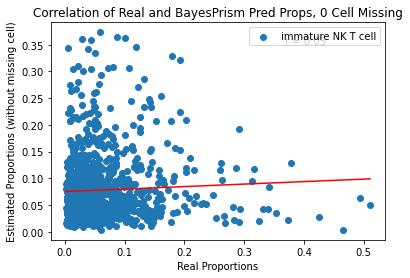

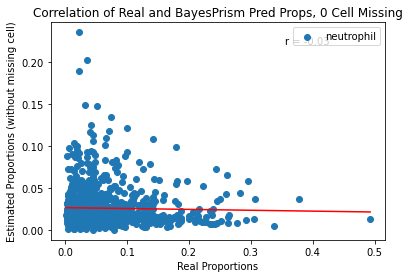

In [20]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in real_prop[num].columns:
    x = real_prop[num][col_cell].values.astype(float)
    y = bp_prop[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and BayesPrism Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 16)
Estimated Proportions shape: (1000, 16)


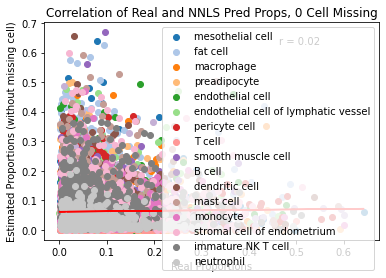

Real Proportions shape: (1000, 15)
Estimated Proportions shape: (1000, 15)


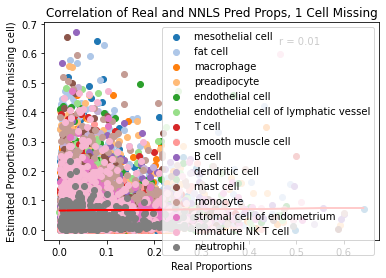

Real Proportions shape: (1000, 14)
Estimated Proportions shape: (1000, 14)


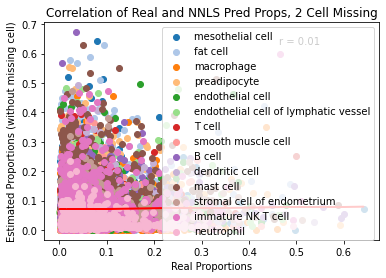

Real Proportions shape: (1000, 13)
Estimated Proportions shape: (1000, 13)


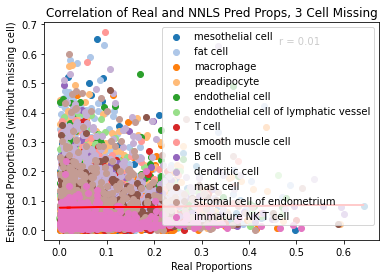

Real Proportions shape: (1000, 12)
Estimated Proportions shape: (1000, 12)


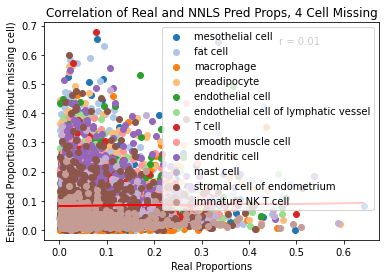

Real Proportions shape: (1000, 8)
Estimated Proportions shape: (1000, 8)


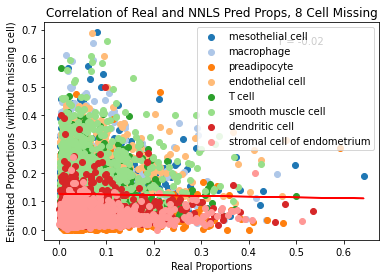

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


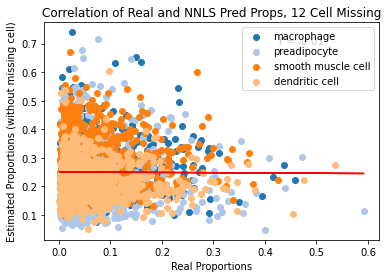

In [21]:
#Comparnig performance for all cell types with num_cells_missing.
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float) #real proportions of present cells
    estimated_proportions = bp_prop[num].values.astype(float) #estimated proportions of present cells.
    cell_types = real_prop_reb[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='best')  #show the cell type labels in the legend
    plt.show()

Compare References:

In [22]:
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - bp_prop[num]

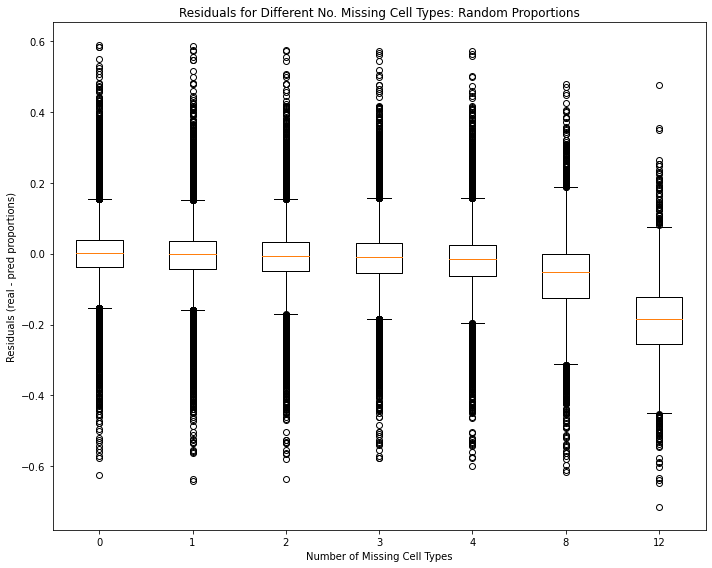

In [23]:
#Distribution of residuals as the difference between calculated and real proportions.
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - bp_prop[num]


fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

## **Extracting Missing Cell Information:**

In [24]:
cells_to_miss = dict()
missing_cell_tot  = dict()
for num in num_missing_cells:
    #cells that are missing
    cells_to_miss[num] = np.setdiff1d(ref_df[0].columns, ref_bp[num].columns)
    #extracting real proportions from missing cells
    missing_cell_tot[num] = real_prop[0][cells_to_miss[num]]
    print(f"{num} missing: {missing_cell_tot[num].shape}")

0 missing: (1000, 0)
1 missing: (1000, 1)
2 missing: (1000, 2)
3 missing: (1000, 3)
4 missing: (1000, 4)
8 missing: (1000, 8)
12 missing: (1000, 12)


In [25]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = real_prop[0][missing_cell_tot[num].columns]  
    print(f"{num} missing: prop is {missing_cell_prop[num].shape}")

1 missing: prop is (1000, 1)
2 missing: prop is (1000, 2)
3 missing: prop is (1000, 3)
4 missing: prop is (1000, 4)
8 missing: prop is (1000, 8)
12 missing: prop is (1000, 12)


## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (ref_bp) * calculated proportions (calc_prop_tot))

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [26]:
#Residual: pseudobulks as used, minus reference of BP * calculated proportions
residuals = dict()
for num in num_missing_cells:
    #cutting pseudobulk to match reference genes
    pseudo_df_ = pseudo_df[num][ref_bp[num].index]
    res = pseudo_df_.values - (bp_prop[num] @ ref_bp[num].T)
    residuals[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals[0]    

ValueError: matrices are not aligned

In [ ]:
ref_bp_scaled = dict()
pseudo_scaled = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    ref_raw_val = ref_bp[num].values ##reference of bayes prism
    clip_upper = np.quantile(ref_raw_val, 0.90)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_scale = scaler.transform(ref_raw_val)
    ref_bp_scaled[num] = pd.DataFrame(ref_scale, index = gene_ids[num], columns = real_prop[num].columns)

    #clippign before scaling to 95th pecentile
    pseudo_raw_val = pseudo_df[num][ref_bp[num].index].values ##pseudobulks
    clip_upper = np.quantile(pseudo_raw_val, 0.90)
    pseudo_raw_val = np.clip(pseudo_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    pseudo_scaled[num] = pd.DataFrame(pseudo_scale, columns = gene_ids[num])

In [ ]:
print(ref_bp[1].max().max())
print(ref_bp_scaled[1].max().max())

In [ ]:
print(pseudo_df[1].max().max())
print(pseudo_scaled[1].max().max())

In [ ]:
#Residual with the scaled pseudobulk and scaled bayes prism reference
residuals_scaled = dict()
for num in num_missing_cells:
    res = (pseudo_scaled[num].values)  - (bp_prop[num] @ ref_bp_scaled[num].T)
    residuals_scaled[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals_scaled[0]    

## NMF

In [ ]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

In [ ]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf)
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df

In [ ]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift_scaled = residuals_scaled
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift_scaled[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift_scaled[num][residuals_shift_scaled[num].values <= 0] = 0
    data = residuals_shift_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
#nmf on residual 1
res_nmf_scaled = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf)
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf_scaled[num] = res_nmf_df

Residual

In [ ]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter=5000)
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_heatmaps(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Residual_scaled

In [ ]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num + 1
    nmf = NMF(n_components = num_nmf, max_iter = 5000)
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_heatmaps(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 